#### 1. Сформулируйте нулевые и альтернативные гипотезы и проведите следующие тесты:
1. Одновыборочный параметрический тест
2. Двухвыборочный параметрический и непараметрический тесты
3.  Параметрический и непараметрический тесты для парных наблюдений

*Из пяти перечисленных тестов как минимум два нужно сделать вручную (т.е. статистику для теста нужно посчитать самостоятельно, без использования готовой функции из пакета*



In [110]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.utils import resample
import scipy.stats as stats
%matplotlib inline

Загрузим данные:

In [83]:
data = pd.read_csv('salaries.csv',header = 0)

In [84]:
print "Количество записей: ",len(data)
print "Количество уникальных записей JobTitle",len(data['JobTitle'].unique())
print "Количество уникальных записей AgencyTitle",len(data['AgencyTitle'].unique())

Количество записей:  52256
Количество уникальных записей JobTitle 4072
Количество уникальных записей AgencyTitle 120


Видно, что различных "AgencyTitle" на порядок меньше "JobTitle", поэтому в первую очередь попробуем разбить выборку по типам "AgencyTitle"

**0. Для начала, посмотрим на данные**

Посмотрим, записей для какого Agency больше всего

In [85]:
data["AgencyTitle"].value_counts()[:10]

University of Washington          14359
Social and Health Services         7055
Transportation                     4492
Corrections                        2013
Western Washington University      1376
Seattle Community College          1162
Employment Security Department     1121
Labor and Industries               1067
Eastern Washington University      1052
Spokane Community College          1012
Name: AgencyTitle, dtype: int64

Выделим выборку из 1000 записей

In [111]:
samplesize = 1000
population = data[data["AgencyTitle"] == 'University of Washington']
sample = population.sample(n = samplesize)

Попробуем взглянуть на Salaries2011 у Washington 

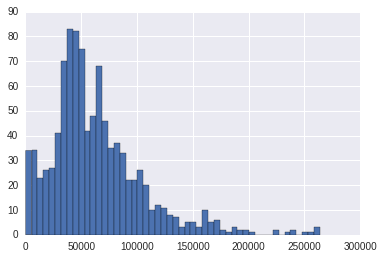

In [87]:
sample['Salary2011'].hist(bins = 50)

видно, что данные "сильно смещены" в лево. Возможно, зарплата за 2011 год подчиняется логнормальному распределению. Применим к каждому элементу этого столбца функцию log(1 + x) и посмотрим на гистограмму распределений 

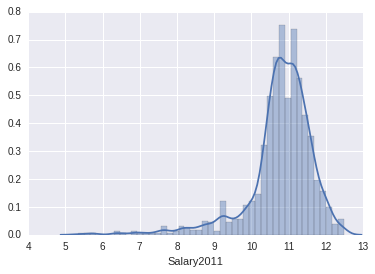

In [88]:
sns.distplot(sample['Salary2011'].apply(np.log),kde = True)

In [89]:
log_salaries = sample['Salary2011'].apply(np.log)

Выдвинем гипотезу о том, что заработная плата за 2011 год имеет логнормальное распределение. Или же прологорифированная выборка подчиняется нормальному распределению. 

Мы видим, что p value ,близко к 0, значит гипотеза о нормальности не выполняется. Возможно из-за неравномерных хвостов у этого распределения

In [90]:
stats.shapiro(log_salaries.values)

(0.8540631532669067, 2.0632439345971848e-29)

** 1. Гипотезы и тесты будем выдвигать последовательно**

Подсчитаем выборочное среднее зарплаты за 2010

Выдвинем гипотезу (гипотеза 1) среднее значение заработной платы за 2011 год равно 65500:
$$ H_0: \mu = 65500$$
альтернативную гипотезу будем считать двусторонней
$$ H_1: \mu \neq 65500$$

In [91]:
def my_sample_mean(series):
    mean = 0
    N = float(len(series))
    for value in series.values:
        mean += value/N
    return mean

def my_unbiased_std(series):
    mean = my_sample_mean(series)
    std = 0
    N = float(len(series))
    for value in series.values:
        std += (1/(N - 1))*(value - mean)**2
    return np.sqrt(std)

In [92]:
x_bar = my_sample_mean(sample['Salary2011'])

1.1 Проведём однопараметрический тест Стьюдента. Уровень доверия выберем 0.95:

In [93]:
mu = 65500
s = my_unbiased_std(sample['Salary2011'])
t_obs = np.sqrt(len(sample))*(x_bar - mu)/s

In [94]:
print "5% quantile:",stats.t.ppf(q = 0.025, df = samplesize-1)
print "observed t:", t_obs
print "95% quantile:",stats.t.ppf(q = 0.975, df = samplesize-1)

5% quantile: -1.96234146113
observed t: -1.77654891023
95% quantile: 1.96234146113


Мы видим, что наблюдаемая величина выборочного среднего попадает в интервал $[ q_{0.05},q_{0.95}]$

Подсчитаем величину P value:

In [95]:
p_value_1 = min(2*(1 - stats.t.cdf(t_obs,samplesize-1)),2*(stats.t.cdf(t_obs,samplesize-1)))
print "P value = ",p_value_1

P value =  0.0759467594375


==========================================================================================================

1.2 Проверим гипотезу (гипотеза 2) о том, что средние значения зарплат за 2011 год в "University of Washington" и "Social and Health Services" равны используя двухвыборочный t-критерий Стьюдента:
$$ H_0:  \mu_1 = \mu_2 $$

Размеры выборок для простоты выберем одинаковыми и равными 1000

In [96]:
sample_1 = data[data["AgencyTitle"] == 'University of Washington'].sample(n = samplesize)
sample_2 = data[data["AgencyTitle"] == 'Social and Health Services'].sample(n = samplesize)

x_bar_1 = my_sample_mean(sample_1['Salary2011'])
x_bar_2 = my_sample_mean(sample_2['Salary2011'])
s_1 = my_unbiased_std(sample_1['Salary2011'])
s_2 = my_unbiased_std(sample_2['Salary2011'])

t_obs = np.sqrt(samplesize)*(x_bar_1 - x_bar_2)/np.sqrt(s_1**2 + s_2**2)

In [97]:
print "5% quantile:",stats.t.ppf(q = 0.025, df = 2*samplesize-2)
print "observed t:", t_obs
print "95% quantile:",stats.t.ppf(q = 0.975, df = 2*samplesize-2)

5% quantile: -1.96115201484
observed t: 11.9514384463
95% quantile: 1.96115201484


Видно, что наблюдаемое значение статистики не принадлежит доверительному интервалу.

Величина P value при этом равна:

In [98]:
p_value_2 = min(2*(1 - stats.t.cdf(t_obs,samplesize-1)),2*(stats.t.cdf(t_obs,samplesize-1)))
print "P value = ", p_value_2

P value =  0.0





============================================================================================================




Проведём непараметрический sign тест, в котором выясним, одинаковые ли медианы (гипотеза 3) распределений выбранных нами выборок:

In [99]:
bin1 = sum(sample_1['Salary2011'] < sample_2['Salary2011'])
bin2 = sum(sample_1['Salary2011'] != sample_2['Salary2011'])
p_value_3 = stats.binom_test(bin1, bin2, p=0.5)
print "P value:", p_value_3

P value: 6.88698412518e-15


Так как P value говорит нам о том, насколько вероятно наблюдать полученное значение статистики при условии справедливости нулевой гипотезы, то из близости P value к нулю можем заключить, что скорее всего медианы данных распределений не равны 

============================================================================================================

1.3 Проверим на равенство средние значения зарплат за 2011 и 2012 год (гипотеза 4) при помоши t-теста

In [100]:
p_value_4 = stats.ttest_ind(sample['Salary2011'],sample['Salary2012'])[1]
print "P value:", p_value_4

P value: 0.605465590871


P value достаточно высоко, можно заключить, что среднее значение зарплат не изменилось

Ну, и наконец, проведём непараметрический тест Манна-Уитни (гипотеза 5)

In [101]:
p_value_5 = stats.mannwhitneyu(sample['Salary2011'],sample['Salary2012'])
print "P value:", p_value_5

P value: MannwhitneyuResult(statistic=492775.0, pvalue=0.28792119941298572)


=============================================================================================================

#### 2. Сформулируйте точную альтернативную гипотезу для одного из проведенных тестов и оцените мощность теста




В пункте 1.1 была сформулирована гипотеза, что среднее значение заработной платы за 2011 год равно 65500:
$$ H_0: \mu = \mu_0 = 65500.$$

Конкретизируем альтернативную гипотезу $$H_1: \mu > 65500$$
Для определённости будем считать $\mu_1 = 67000$, а уровень значимости $\alpha = 0.05$.

In [102]:
mu_0 = 65500
mu_1 = 67000

t_95 = stats.t.ppf(0.95,samplesize - 1)
s = sample['Salary2011'].std()

Мощность теста по определению вероятность отклонить гипотезу H_0, если на самом деле верна альтернативная гипотеза H. 
Мы отвергаем нулевую гипотезу, при $t_{observed}(\mu_0) > t_{0.95}$, где $t_{0.95}$ - 95% квантиль t-распределения Стьюдента. 
Тогда $$\bar{X} - \mu_0 > t_{0.95}\frac{s}{\sqrt n}  \rightarrow \bar{X} - \mu_1 > \mu_0 - \mu_1 +  t_{0.95}\frac{s}{\sqrt n} \rightarrow t_{observed}(\mu_1) = \frac{\bar{X} - \mu_1}{s/\sqrt n} > \frac{\mu_0 - \mu_1}{s/\sqrt n} + t_{0.95}$$

Следовательно, мощностью теста будет являться вероятность наблюдения $t_{observed}(\mu_1) > \frac{\mu_0 - \mu_1}{s/\sqrt n} + t_{0.95}$

In [103]:
power = stats.t.sf((mu_0 - mu_1)/(s/np.sqrt(samplesize)) + t_95, samplesize - 1)
print "Power is: ",power

Power is:  0.303328368976


*Построим power plot для различных значений $\mu_1$ - средних альтернативной гипотезы*

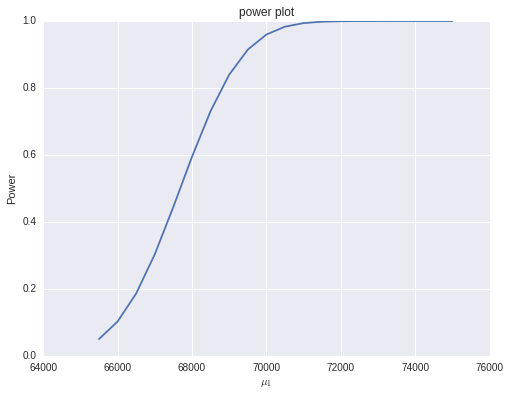

In [104]:
powers = []
for mu_1 in np.arange(mu_0, mu_0 + 10000, 500):
    power = stats.t.sf((mu_0 - mu_1)/(s/np.sqrt(samplesize)) + t_95, samplesize - 1)
    powers.append(power)
powers = np.array(powers)

plt.figure(figsize = (8,6))
plt.plot(np.arange(mu_0, mu_0 + 10000, 500), powers)

plt.title('power plot')
plt.ylabel('Power')
plt.xlabel('$\mu_1$')

*из power plot видно, что мощность более 0.8 достигается при значениях среднего у альтернативной гипотезы более 69500*

#### 3. Рассматривая проведенные тесты как единую группу, сделайте поправку на множественное тестирование (FDR, Bonferroni, Sidak, Bonferroni-Holm). Изменились ли результаты?


Указание в лекции: 

    **Метод Бонферрони**

    Метод достаточно прост: мы рассчитываем p-value для каждой гипотезы в отдельности и отвергаем "глобальную" нулевую гипотезу только в том случае, если минимальное p-value меньше чем alpha.

Проведём данную поправку

In [167]:
p_values = [
    p_value_1,
    p_value_2,
    p_value_3,
    p_value_4,
    p_value_5
]

alpha = 0.05
n = len(p_values)

rejected_hypotheses = []

for i,p_value in enumerate(p_values):
    if p_value < alpha/n:
        rejected_hypotheses.append(i+1)
        print "Hypothesis {} is rejected".format(i+1)

print "Number of rejections is:", len(rejected_hypotheses)

Hypothesis 2 is rejected
Hypothesis 3 is rejected
Number of rejections is: 2


#### 4. Постройте параметрические доверительные интервалы для среднего и непараметрические интервалы для медианы на основе бутстрепа


Для начала построим непараметрический интервал для медианы:

In [123]:
init_median = np.median(population['Salary2011'])

In [124]:
init_median

53424.0

In [125]:
errs = []
for i in xrange(1000):
    errs.append(init_median-resample(population['Salary2011'], replace=True).median())

In [127]:
print "5 percentile is: ",init_median + np.percentile(np.sort(errs), 5)
print "95 percentile is: ",init_median + np.percentile(np.sort(errs), 95)

5 percentile is:  52848.0
95 percentile is:  54178.0
